# Stock Price Prediction Using LSTM and Twitter Data

### Abstract

This notebook uses the Same LSTM Model built in the Jupyter Notebook along with one additional input which is the Twitter Sentimental Analysis Data from TwitterSentimetalAnalysis Notebook. We combine the stock price and the Twitter data and feed it to the LSTM and then we analyze the residual errors and compare it with the original LSMT model. We compare it using QQ plots to understand if the errors are nornamly distributed. 

### Importing libraries and data

Importing all necessary libraries
The main library used for creating the neural network is Keras
Other libraries like Pandas, Numpy, Sklearn are used to import and work on data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
from sklearn.model_selection import train_test_split
import pickle

Using TensorFlow backend.


We import the same stock data that we imported for the original model.

In [2]:
#stock_code = "PYPL"
#api_key = ""
#url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock_code+"&apikey="+ api_key +"&datatype=csv&outputsize=full"
#df = pd.read_csv(url)

df = pd.read_csv("daily_PYPL.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2019-07-19,120.74,121.36,118.60,118.63,4913977
1,2019-07-18,118.99,120.80,118.63,119.87,4440672
2,2019-07-17,119.65,119.99,118.80,118.81,4627478
3,2019-07-16,121.10,121.48,119.53,119.71,4006838
4,2019-07-15,120.77,121.04,119.80,120.90,3721345


In [3]:
df.shape

(1008, 6)

We are only going to work with the Open values for the stock so we select just the "Open" Column and reshape the data frame 

In [4]:
df = df['open'].values[:500]
df = df.reshape(-1, 1)

Plotting open Prices for visualizing the data.

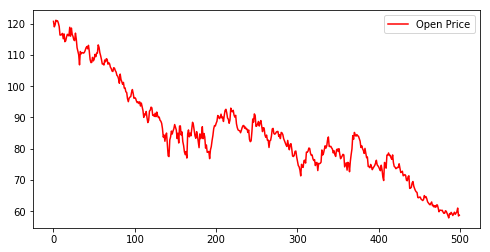

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="Open Price")
plt.legend()

### Creating data for training LSTM


The stock price data which we would be using for training and testing will consist of a bunch of 50 sequential values as X and the next value as its corresponding y Which is same as the one which we used in the original model.

### Creating Training and testing datasets

We split the data into 80% training and 20% testing dataset.


In [6]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(400, 1)
(150, 1)


The data values do not have a specific range and have to be normalized so that it can be feed into the model.
Here we use MinMaxScaler to scale the values between 0 and 1.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))

Scaling training and testing data

In [8]:
dataset_train = scaler.fit_transform(dataset_train)

In [9]:
dataset_test = scaler.transform(dataset_test)

### Importing Twitter Feed Scores

We load the Twitter score data that we created in the TwitterSentimentalAnalysis Notebook.


In [10]:
twitter_score = pickle.load(open('tweetScore.data', 'rb'))

In [11]:
twitter_score = np.asarray(twitter_score)

We scale the score so that they can be feed into the LSTM model

In [12]:
t_scaler = MinMaxScaler(feature_range=(0,1))
twitter_score = t_scaler.fit_transform(twitter_score.reshape(-1,1))

Creating method for generating dataset with X and y.
Here we bundle 50 sequental values togeter to form a single x which corresponds to a y which will be the next value in the sequence. Along with the stock data we pass in the Twitter scores which will get bundled into the X parameters 

In [13]:
def create_dataset(df,tweetScoreList):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(np.append(df[i-50:i, 0],tweetScoreList[i-50]))
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

Applying the method on train and test data.

In [14]:
x_train, y_train = create_dataset(dataset_train,twitter_score[:350])

In [15]:
x_test, y_test = create_dataset(dataset_test,twitter_score[350:])

In [16]:
x_train.shape

(350, 51)

Reshaping X values so that the LSTM layers can take them as inputs

In [17]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
x_test.shape

(100, 51, 1)

In [19]:
x_train.shape

(350, 51, 1)

### LSTM Model

We create and train the LSTM model the same way as the orginal. But her we feed in the Twitter Data as well.
Here we will create a Neural Network using one input LSTM layer, one output LSTM layer and 2 hidden LSTM layers.
Each LSTM layers will have 100 units each.
We will set drop out to 0.2 for regularizing the neural network.

In [20]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

W0812 22:48:47.636682 140261005305600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 22:48:47.652830 140261005305600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 22:48:47.655765 140261005305600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 22:48:47.847429 140261005305600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0812 22:48:47.854523 

We will use mean squared error as the loss function
And Adam optimizer while training the model

In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')


W0812 22:48:48.594378 140261005305600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Fitting the model for 50 epochs and batch size as 30

In [22]:
model.fit(x_train, y_train, epochs=50, batch_size=30, verbose=0)

W0812 22:48:48.868191 140261005305600 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 22:48:51.187283 140261005305600 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



### Testing the model

We will now try to create predictions using the test data and plot them to visualize the predictions

In [23]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Ploting the test data prices along with the Predicted values  

In [38]:
orignal_pred = pickle.load(open('predictions.data','rb'))

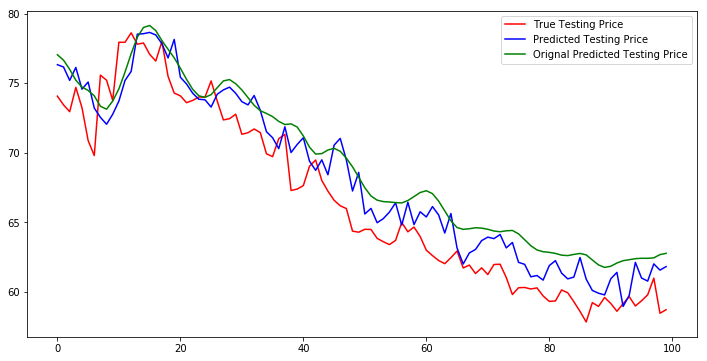

In [42]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.plot(orignal_pred, color='green', label='Orignal Predicted Testing Price')
plt.legend()

#### Observation:
We can observe rthat the 

Calculating the Residuals which will help us plot the QQ plots and Error Bar plots. So that we can analyze and compare the original and new model.  

In [26]:
residual_errors = y_test_scaled - predictions

<ErrorbarContainer object of 3 artists>

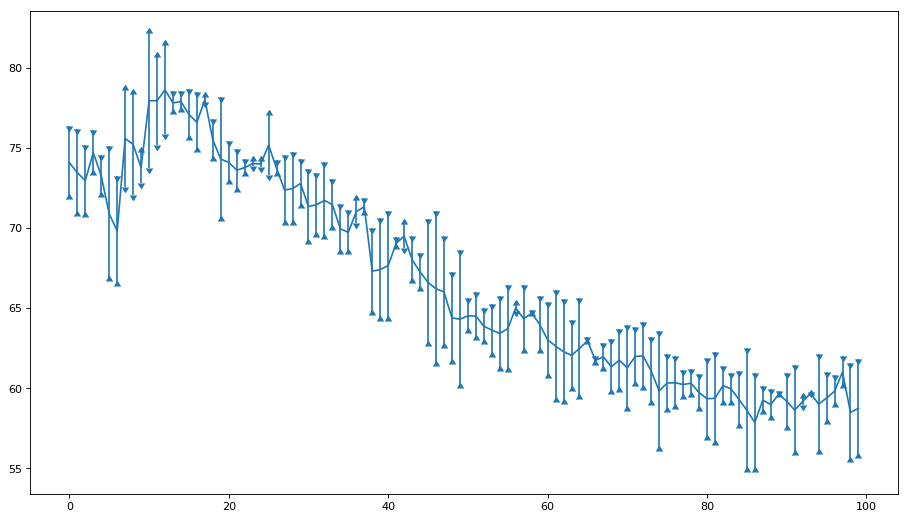

In [27]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(np.arange(len(y_test_scaled)),y_test_scaled,yerr=residual_errors,uplims=True, lolims=True)

Below is the QQ plot for the residuals using the new model

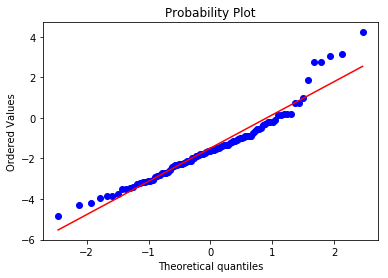

In [28]:
from scipy import stats
res = stats.probplot(residual_errors.flatten(), plot=plt)
plt.show()

Below is the QQ plot for the original data for comparison.

In [45]:
orig_residual = pickle.load(open('original_residual.data','rb'))

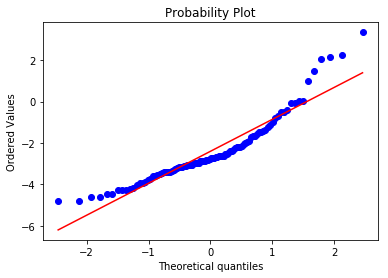

In [46]:
res = stats.probplot(orig_residual.flatten(), plot=plt)
plt.show()

### Observations:

We can clearly see that there is an improvement ovre the original model. That is the Twitter feed data has an impact on predicting the stock prices. We will need to further analyze the co-relation between the tweeter feeds and the stock prices.

In [29]:
mean = residual_errors.mean()
std_div = residual_errors.std()
print("Mean:"+str(mean)+" Std Div:"+str(std_div))

Mean:-1.4894849380493174 Std Div:1.6557008821438028


In [47]:
org_mean = orig_residual.mean()
org_std_div = orig_residual.std()
print("Mean:"+str(org_mean)+" Std Div:"+str(org_std_div))

Mean:-2.407051885986329 Std Div:1.5964953514750642


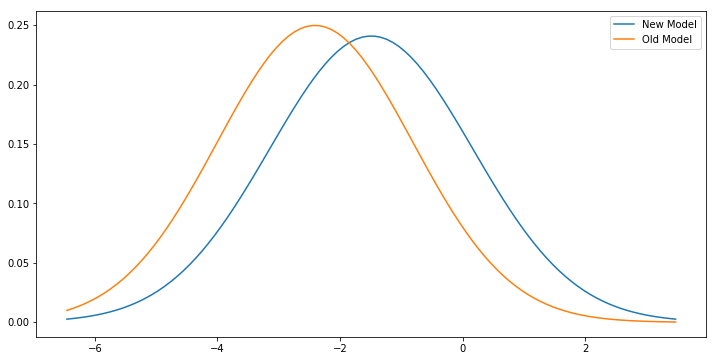

In [50]:
x = np.linspace(mean - 3*std_div, mean + 3*std_div, 100)
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(x, stats.norm.pdf(x, mean, std_div), label='New Model')
plt.plot(x, stats.norm.pdf(x, org_mean, org_std_div), label='Old Model')
plt.legend()
plt.show()

The curve for the new model has its mean slightly closer to zero. Which means that the errors are slightly evenly distributed as compared to the original model.

### Observations:

On futher analysis of the twitter feeds we observe the following
* Some of the tweets contain data that describe the stock price which has a compounding positive effect on predicting the prices.(Eg: `$PYPL nice entry` has a score of 0.6) which might not be that useful. 
* Some tweets are not specific to the stock market but migh have an indirect impact. (Eg. `$PYPL showing the best technicals its sector http://stockcharts.chartmill.com/u/Hkgq6ImZA- #Construct2 #ML` which has a score of 1). These tweets seem useful.
* Some tweets are like news about the stock (Eg: `These were up good until the eod dip.. all good though! $PYPL https://twitter.com/warrenpuffett9/status/992454025772756994` which have a score of 0.7875). These might not be that useful as they only reflect what has already occured.


### Conclusion

The overall analysis of the tweets and there impact show us that even though sentimental analysis score of twitter feeds does help in predicting the stock prices, the twitter feeds might not be a very reliable source of information which can be actually used to predict future prices. This is because mostly twitter feeds contain data about what has alrady happened. Selecting the relavant tweets from the feed might be a solution that could help identify a trend. But that would require us to build a model to scrape though all the tweets and selecting only those tweets that are relevant. For this project and notebook we took samples from twitter feed and used them for analysis. 

For future scope we can develope a Tweets Classifier (maybe a Neural network) that could possibly select tweets that are relavant to predicting stocks (This classifier would be similar to a spam filter which selects the important messages).  

### Contributions
1. Code contributed by me ~ 60% code
2. From other sources ~ 40% code

### Citation
1. [Stock Market Prediction by Recurrent Neural Network on LSTM Model](https://blog.usejournal.com/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68)
2. [Stock market prediction](https://en.wikipedia.org/wiki/Stock_market_prediction)
3. [Stock Price Prediction using a Recurrent Neural Network](https://www.youtube.com/watch?v=lpU3PGyDKQ4)

<div class="alert alert-block alert-info">
MIT License 

Copyright (c) 2019 Ninad Subhedar 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: 

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</div>